In [1]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# 발급받은 인코딩된 서비스키를 사용하세요.
service_key = 'mUglWToAvQmeYwqfOR1UwESkdwoUdkYmZTS5lWDf5pEGuh1gvgyfIy%2BtFKzTNsFYqE%2BM0a6NlwJGtxyhBV63sQ%3D%3D'

def get_stock_code(stock_name):
    """종목명을 입력받아 종목 번호 조회"""
    url = f"https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo?serviceKey={service_key}&numOfRows=1&pageNo=1&resultType=json&itmsNm={stock_name}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get('response', {}).get('body', {}).get('items', {}).get('item', [])
        
        if items:
            # 종목 코드 추출
            stock_code = items[0].get('srtnCd', '')  # 짧은 종목 코드 가져오기
            market_type = items[0].get('mrktCtg', '')  # 시장 구분 (KOSPI/KOSDAQ)
            
            # yfinance 형식으로 변환
            suffix = '.KS' if market_type == 'KOSPI' else '.KQ'
            return f"{stock_code}{suffix}"
        else:
            print("해당 종목명을 찾을 수 없습니다.")
            return None
    else:
        print(f"API 호출 실패: {response.status_code}")
        return None

In [2]:
def get_stock_data(stock_name, period='5y', interval='monthly'):
    """종목명으로 yfinance 데이터를 불러오기"""
    ticker = get_stock_code(stock_name)
    if ticker is None:
        return None

    # yfinance로 주식 데이터 불러오기
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)

    # 원하는 데이터 재구성
#     if interval == 'weekly':  # 주 단위 데이터
#         df_resampled = df['Close'].resample('W-MON').last().reset_index()
    if interval == 'monthly':  # 월말 데이터
        df_resampled = df['Close'].resample('M').last().reset_index()
    elif interval == 'semi_monthly':  # 월중(15일) 및 월말 데이터
        # 날짜에서 필요한 정보 추출
        df = df.reset_index()  # 인덱스를 초기화하여 `Date` 열로 변환
        df['Day'] = df['Date'].dt.day
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # 월말 데이터: 각 달의 마지막 날짜
        df['Month_End'] = df['Date'] == df.groupby(['Year', 'Month'])['Date'].transform('max')
        
        # 월중(15일) 데이터와 월말 데이터 필터링
        mid_month_data = df[df['Day'] == 15]  # 월중 (15일)
        end_month_data = df[df['Month_End']]  # 월말 데이터
        
        # 월중 및 월말 데이터를 병합
        df_resampled = pd.concat([mid_month_data, end_month_data]).sort_values('Date').reset_index(drop=True)
    else:
        raise ValueError("지원되지 않는 interval 값입니다. 'weekly', 'monthly', 'semi_monthly' 중 하나를 선택하세요.")

    # 필요한 열만 반환
    return df_resampled[['Date', 'Close']]

def cal_increase(stock_name, interval):
    if interval == 'monthly':
        df_monthly = get_stock_data(stock_name, interval='monthly')
        df_monthly['Increase'] = df_monthly['Close'].diff()
        df_monthly = df_monthly.dropna().reset_index(drop=True)
        return df_monthly
    elif interval == 'semi_monthly':
        df_semi_monthly = get_stock_data(stock_name, interval='semi_monthly')
        df_semi_monthly['Increase'] = df_semi_monthly['Close'].diff()
        df_semi_monthly = df_semi_monthly.dropna().reset_index(drop=True)
        return df_semi_monthly

In [3]:
def cal_data(stock_name, interval='monthly'):
    """
    주어진 종목 데이터를 기반으로 월별 또는 월중(15일) 및 월말 통계량 계산.
    
    Parameters:
    - stock_name: str, 종목 이름
    - interval: str, 데이터 주기 ('monthly', 'semi_monthly')
    
    Returns:
    - DataFrame: 통계량이 포함된 결과 데이터프레임
    """
    if interval == 'monthly':
        df_monthly = cal_increase(stock_name, interval='monthly')
        monthly_increase_data = df_monthly['Increase']
        monthly_mean = monthly_increase_data.mean()                  # 평균    
        monthly_std = monthly_increase_data.std()                    # 표준편차 
        monthly_lower_bound = monthly_mean - 1.96 * monthly_std      # 하한
        monthly_upper_bound = monthly_mean + 1.96 * monthly_std      # 상한
        df_monthly['Increase'] = df_monthly['Increase'].clip(lower=monthly_lower_bound, upper=monthly_upper_bound)
        
        # 전체 데이터를 월별로 그룹화하여 통계량 계산
        df_monthly['Month'] = df_monthly['Date'].dt.month
        monthly_stats = df_monthly.groupby('Month')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts = df_monthly[df_monthly['Increase'] > 0].groupby('Month')['Increase'].count()

        # 모든 월을 포함하여 결과 결합 및 누락 값 채우기
        monthly_stats = monthly_stats.join(positive_counts.rename('Increase Count')).reindex(range(1, 13), fill_value=0).reset_index()
        monthly_stats['Increase Count'] = monthly_stats['Increase Count'].fillna(0).astype(int)
        
        return monthly_stats

    elif interval == 'semi_monthly':
        df_semi_monthly = cal_increase(stock_name, interval='semi_monthly')
        semi_monthly_increase_data = df_semi_monthly['Increase']
        semi_monthly_mean = semi_monthly_increase_data.mean()
        semi_monthly_std = semi_monthly_increase_data.std()
        semi_monthly_lower_bound = semi_monthly_mean - 1.96 * semi_monthly_std
        semi_monthly_upper_bound = semi_monthly_mean + 1.96 * semi_monthly_std
        df_semi_monthly['Increase'] = df_semi_monthly['Increase'].clip(lower=semi_monthly_lower_bound, upper=semi_monthly_upper_bound)

        # 월중 및 월말 데이터 처리
        df_semi_monthly['Period'] = df_semi_monthly['Date'].dt.day.apply(
            lambda x: 'Mid' if x < 20 else 'End'
        )  # 15일 이전을 'Mid', 이후를 'End'로 구분

        df_semi_monthly['Month'] = df_semi_monthly['Date'].dt.month
        df_semi_monthly['Month-Period'] = df_semi_monthly['Month'].astype(str) + '-' + df_semi_monthly['Period']

        # 월-기간별 통계량 계산
        semi_monthly_stats = df_semi_monthly.groupby('Month-Period')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts_semi = df_semi_monthly[df_semi_monthly['Increase'] > 0].groupby('Month-Period')['Increase'].count()

        # 결과 결합 및 누락 값 처리
        semi_monthly_stats = semi_monthly_stats.join(positive_counts_semi.rename('Increase Count')).fillna(0).reset_index()
        semi_monthly_stats['Increase Count'] = semi_monthly_stats['Increase Count'].astype(int)

        # Month-Period 순서 정렬
        # Mid=1, End=2로 변환하여 Month, Period 기준으로 정렬
        semi_monthly_stats['Sort_Key'] = semi_monthly_stats['Month-Period'].apply(
            lambda x: (int(x.split('-')[0]), 1 if x.split('-')[1] == 'Mid' else 2)
        )

        # 정렬 후 정렬 키 삭제
        semi_monthly_stats = semi_monthly_stats.sort_values('Sort_Key').drop(columns=['Sort_Key']).reset_index(drop=True)
        
        return semi_monthly_stats

In [4]:
def predict_increase(stock_name, interval='monthly'):
    if interval == 'monthly':
        df_monthly = cal_increase(stock_name, interval='monthly')
        # SARIMA 모델 적용 (계절 주기 12 설정)
        model = SARIMAX(df_monthly['Increase'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 12))
        monthly_model_fit = model.fit()

        # 12개월(1년) 예측
        monthly_forecast = monthly_model_fit.forecast(steps=12)

        # 예측 월 생성 (마지막 관측 월 이후 12개월)
        monthly_start_date = df_monthly['Date'].iloc[-1]  # 마지막 데이터의 날짜
        monthly_forecast_dates = pd.date_range(start=monthly_start_date + pd.DateOffset(months=1), periods=12, freq='M')

        # 예측 결과와 월 정보를 함께 데이터프레임으로 정리
        monthly_forecast_df = pd.DataFrame({'Date': monthly_forecast_dates, 'Predicted_Increase': monthly_forecast})
        return monthly_forecast_df
    elif interval =='semi_monthly':
        df_semi_monthly = cal_increase(stock_name, interval='semi_monthly')
        
        # 'Date' 열을 datetime 형식으로 변환
        if 'Date' in df_semi_monthly.columns and not pd.api.types.is_datetime64_any_dtype(df_semi_monthly['Date']):
            df_semi_monthly['Date'] = pd.to_datetime(df_semi_monthly['Date'])

        # 'Date'를 인덱스로 설정
        if df_semi_monthly.index.name != 'Date':
            df_semi_monthly.set_index('Date', inplace=True)

        model = SARIMAX(df_semi_monthly['Increase'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 12))
        semi_monthly_model_fit = model.fit()

        # 12개월 예측
        semi_monthly_forecast = semi_monthly_model_fit.forecast(steps=24)

        # 예측 날짜 생성: 15일과 월말
        last_date = df_semi_monthly.index[-1]
        forecast_dates = []
        for i in range(1, 13):  # 12개월 동안
            mid_month = (last_date + pd.DateOffset(months=i)).replace(day=15)  # 15일
            end_month = (last_date + pd.DateOffset(months=i + 1)).replace(day=1) - pd.DateOffset(days=1)  # 월말
            forecast_dates.extend([mid_month, end_month])

        # 결과 데이터프레임 생성
        semi_monthly_forecast_df = pd.DataFrame({
            'Date': forecast_dates, 
            'Predicted_Increase': semi_monthly_forecast
        })
        return semi_monthly_forecast_df

In [5]:
monthly_stats = cal_data("SK하이닉스", 'monthly')
monthly_stats

,Month,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1,13294.109375,-10203.640625,-570.179688,-81.696875,9242.624119,8.542610e+07,-6768.921875,3840.148438,2
1,2,21401.687500,-5321.750000,2429.437500,7527.276563,11645.442070,1.356163e+08,886.289062,18240.718750,4
2,3,26979.531250,-8640.343750,-4371.437500,1782.142188,14378.057860,2.067285e+08,-4571.484375,-485.554688,1
3,4,889.328125,-8774.281250,-4320.148438,-3436.631250,4069.543658,1.656119e+07,-5358.156250,380.101562,2
4,5,18873.851562,-4383.976562,-960.062500,5279.057813,10782.845988,1.162698e+08,-2090.695312,14956.171875,2
5,6,27253.882381,-16281.640625,3421.148438,4338.978039,15590.054510,2.430498e+08,480.046875,6821.453125,4
6,7,8124.234375,-23849.528735,-2185.718750,-5113.658872,13799.291099,1.904204e+08,-14400.578125,6743.296875,2
7,8,-1585.226562,-20865.343750,-5760.242188,-7633.381250,7749.524754,6.005513e+07,-7317.414062,-2638.679688,0
8,9,8457.789062,-11524.015625,-3360.125000,-2396.110938,7645.104187,5.844762e+07,-6742.265625,1188.062500,2
9,10,11700.000000,-3896.289062,0.000000,1800.128125,5885.333013,3.463714e+07,-392.367188,1589.296875,2


In [6]:
semi_monthly_stats = cal_data("SK하이닉스", 'semi_monthly')
semi_monthly_stats

,Month-Period,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1-Mid,8640.359375,-7366.171875,3896.265625,1723.484375,8221.495876,6.759299e+07,-1734.953125,6268.312500,2
1,1-End,13294.117188,-10203.664062,-4466.460938,-1115.790625,8915.873827,7.949281e+07,-4800.195312,597.250000,2
2,2-Mid,14135.046875,3151.187500,7718.460938,8180.789062,4658.621214,2.170275e+07,5525.212891,10374.037109,4
3,2-End,9120.375000,-5321.750000,-2264.914062,982.651562,6702.940441,4.492941e+07,-3887.093750,7266.640625,2
4,3-Mid,4977.125000,-10142.921875,-5801.339844,-4192.119141,6497.966301,4.222357e+07,-7637.564453,-2355.894531,1
5,3-End,20486.654129,-4371.437500,2230.929688,4832.680826,10428.649032,1.087567e+08,-3840.117188,9657.375000,3
6,4-Mid,5184.812500,-9742.101562,4800.179688,80.963542,8509.197473,7.240644e+07,-2470.960938,4992.496094,2
7,4-End,4383.960938,-13959.093750,380.109375,-3485.207812,7704.840338,5.936456e+07,-9120.351562,889.335938,3
8,5-Mid,-1710.554688,-3063.304688,-2386.929688,-2386.929688,956.538698,9.149663e+05,-2725.117188,-2048.742188,0
9,5-End,20486.654129,-4383.960938,-380.132812,5943.737076,11034.438442,1.217588e+08,-960.046875,14956.171875,2


In [7]:
monthly_pred = predict_increase("SK하이닉스", 'monthly')
monthly_pred

C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


,Date,Predicted_Increase
60,2024-12-31 00:00:00+09:00,4219.975496
61,2025-01-31 00:00:00+09:00,3733.239122
62,2025-02-28 00:00:00+09:00,5822.328242
63,2025-03-31 00:00:00+09:00,3577.402019
64,2025-04-30 00:00:00+09:00,-5038.359351
65,2025-05-31 00:00:00+09:00,7035.814401
66,2025-06-30 00:00:00+09:00,13713.291778
67,2025-07-31 00:00:00+09:00,-15853.006558
68,2025-08-31 00:00:00+09:00,-11460.472344
69,2025-09-30 00:00:00+09:00,-4883.243838


In [8]:
semi_monthly_pred = predict_increase("SK하이닉스", 'semi_monthly')
semi_monthly_pred

C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Date,Predicted_Increase
100,2024-12-15 00:00:00+09:00,-187.078056
101,2024-12-31 00:00:00+09:00,-1062.901056
102,2025-01-15 00:00:00+09:00,6017.226214
103,2025-01-31 00:00:00+09:00,10722.727046
104,2025-02-15 00:00:00+09:00,-1325.826193
105,2025-02-28 00:00:00+09:00,-10832.115659
106,2025-03-15 00:00:00+09:00,-5411.398274
107,2025-03-31 00:00:00+09:00,2386.135563
108,2025-04-15 00:00:00+09:00,3996.252491
109,2025-04-30 00:00:00+09:00,-547.434331


In [25]:
import matplotlib.pyplot as plt

def plot_stats_dual_axis(stats_df, interval):
    """
    통계 데이터를 이중 축으로 시각화.
    - 왼쪽 y축: Median (Increase)
    - 오른쪽 y축: Increase Count

    Parameters:
    - stats_df: DataFrame, 통계 데이터
    - interval: str, 주기 ('monthly', 'semi_monthly')
    """
    # 그래프 크기 설정
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # x축 데이터 설정
    x_labels = stats_df['Month'] if interval == 'monthly' else stats_df['Month-Period']
    
    # 왼쪽 y축: Median 꺾은선 그래프
    ax1.set_xlabel('Month' if interval == 'monthly' else 'Month-Period', fontsize=12)
    ax1.set_ylabel('Median (Increase)', fontsize=12, color='red')
    ax1.plot(x_labels, stats_df['Median'], marker='o', color='red', label='Median (Increase)', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # 오른쪽 y축: Increase Count 막대 그래프
    ax2 = ax1.twinx()  # 공유된 x축을 사용하는 두 번째 y축 생성
    ax2.set_ylabel('Increase Count', fontsize=12, color='darkorange')
    ax2.bar(x_labels, stats_df['Increase Count'], alpha=0.6, label='Increase Count (Max=5)', width=0.4, color='darkorange')
    ax2.tick_params(axis='y', labelcolor='black')

    # 그래프 제목 및 x축 레이블 설정
    title = 'Monthly Statistics' if interval == 'monthly' else 'Semi-Monthly Statistics'
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, fontsize=10)

    # 레전드 추가
    ax1.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)

    # 그래프 출력
    plt.tight_layout()
    plt.show()

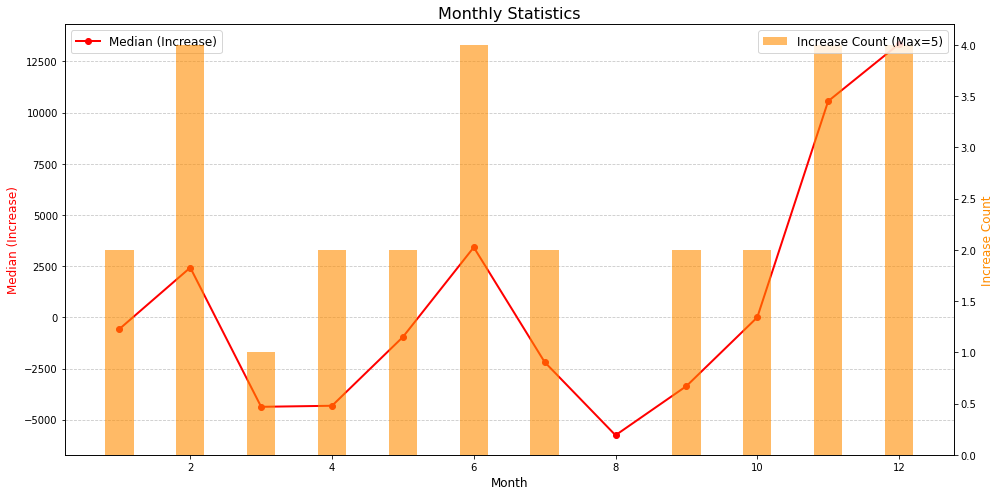

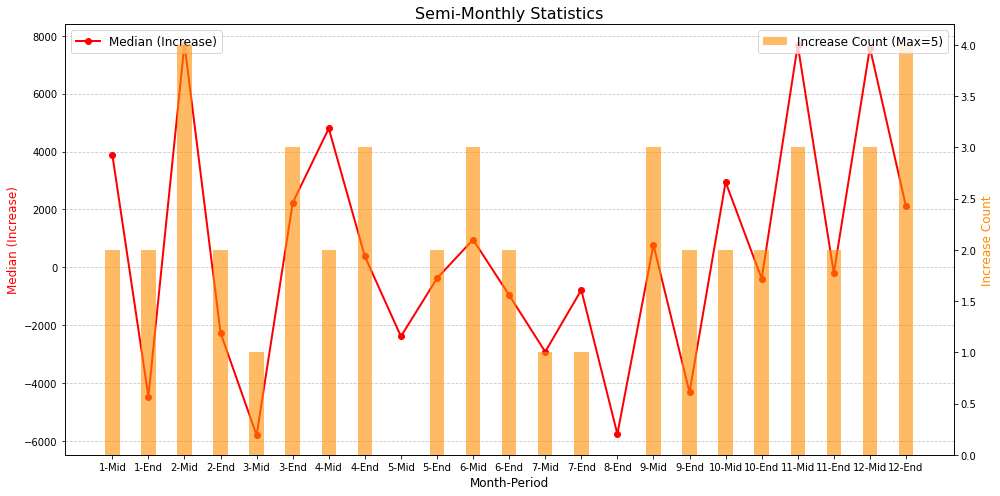

In [26]:
# 월별 데이터 시각화
plot_stats_dual_axis(monthly_stats, interval='monthly')

# 반월별 데이터 시각화
plot_stats_dual_axis(semi_monthly_stats, interval='semi_monthly')